# Classification of cars using CNN and transfer learning

## Introduction

In this project, I will tackle a classification problem using the [stanford car dataset](https://ai.stanford.edu/~jkrause/cars/car_dataset.html). This dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g. 2012 Tesla Model S or 2012 BMW M3 coupe. **The objective of this project is to train a deep learning model that takes an image of a car as input and then output its class**.

Due to the limited number of images, it is difficult to train a deep learning model from scratch with this dataset. Therefore I will leverage the power of **transfer learning**, a common approch used in deep learning (especially in computer vision) and use a pretrained efficientnet model and fine-tune it on our own dataset.

## Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms

import timm

import time
import os
import sys
import tqdm
from tqdm.contrib.logging import logging_redirect_tqdm
import PIL.Image as Image
from IPython.display import display
import logging

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
GeForce RTX 2070 Super with Max-Q Design


In [2]:
DATASET_DIR = './stanford_car_dataset/car_data/car_data/'
NUM_CAR_CLASSES = 196
LOG_PATH = ''

## Dataset

The dataset is stored in the following structure:

└── car_data

    ├── test ── <car_class> ── images
    
    └── train ── <car_class> ── images
    
In other words, in each of the train/test directory, there are 196 subdirectories with unique identifiers (the name of the car class). In each of these subdirectories, images belonging to the corresponding car class are stored.

Given the structure of this dataset, the convenient utility tool `torchvision.datasets.ImageFolder`, which is a subclass of `torch.utils.data.Dataset` will prove quite handy.

In [3]:
# ! tree -d ./stanford_car_dataset/car_data/

In [4]:
def get_dataloaders(dataset_dir):
    # To help prevent overfitting, I did some simple augmentation including horizontal flip and rotation here.
    # For more image augmentation options, the albumentations package works really well with pytorch
    # https://github.com/albumentations-team/albumentations

    # On another note, I recently found another helpful package - torchIO which is good for 3d volume dataset
    # https://github.com/fepegar/torchio

    # note: no data augmentation for test data

    width, height = 224, 224
    train_tfms = transforms.Compose([transforms.Resize((width, height)),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomRotation(15),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    test_tfms = transforms.Compose([transforms.Resize((width, height)),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    # create datasets
    train_dset = torchvision.datasets.ImageFolder(root=dataset_dir + "train", transform=train_tfms)
    train_dl = torch.utils.data.DataLoader(train_dset, batch_size=32, shuffle=True, num_workers=6)

    test_dset = torchvision.datasets.ImageFolder(root=dataset_dir + "test", transform = test_tfms)
    test_dl = torch.utils.data.DataLoader(test_dset, batch_size=32, shuffle=False, num_workers=6)
    
    return train_dl, test_dl

## Training function

In [5]:
def train_model(model, train_dl, test_dl, loss_fn, optimizer, scheduler, n_epochs=5):
    
    losses = []
    accuracies = []
    test_losses = []
    test_accuracies = []

    # set the model to train mode initially
    model.train()
    best_test_acc = 0
    for epoch in tqdm.tqdm(range(1, n_epochs+1)):
        running_loss = 0.0
        running_correct = 0.0
        for i, data in enumerate(train_dl, 0):

            # get the inputs and assign them to cuda
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = model(inputs)
            predicted = F.softmax(outputs, dim=-1).argmax(dim=-1)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc
            running_loss += loss.item() * inputs.shape[0]
            running_correct += (labels==predicted).sum().item()

        epoch_loss = running_loss / len(train_dl.dataset)
        epoch_acc = running_correct / len(train_dl.dataset) * 100.0
        
        with logging_redirect_tqdm():
            msg = f"Train Epoch: {epoch}\ttrain_loss: {epoch_loss:.4f}\ttrain_accuracy: {epoch_acc:.4f}%"
            logging.info(msg)
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_loss, test_acc = eval_model(model, test_dl, loss_fn)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            logging.info('Model saved.')
            torch.save(model.state_dict(), 'best_model.pt')
        
        # re-set the model to train mode after validation
        model.train()
        scheduler.step(test_acc)
    print('Finished Training')
    return model, losses, accuracies, test_losses, test_accuracies

## Testing function

In [6]:
def eval_model(model, test_dl, loss_fn):
    correct = 0.0
    total = 0.0
    loss_total = 0.0
    with torch.no_grad():
        for i, data in enumerate(test_dl, 0):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss_total += loss.item() * images.shape[0]
            predicted = F.softmax(outputs, dim=-1).argmax(dim=-1)

            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / len(test_dl.dataset)
    test_loss = loss_total / len(test_dl.dataset)
    
    with logging_redirect_tqdm():
        msg = f'test_loss: {test_loss:.4f}\ttest_accuracy: {test_acc:.4f}%\n'
        logging.info(msg)
    
    return test_loss, test_acc

## Main function

In [7]:
def main():
    train_dl, test_dl = get_dataloaders(DATASET_DIR)
    
    # I use the wonderful timm package to load the pretrained efficientnet model
    # https://github.com/rwightman/pytorch-image-models
    model_ft = timm.create_model('efficientnet_b3', pretrained=True)
    
    # replace the last fc layer with an untrained one (requires grad by default)
    num_ftrs = model_ft.classifier.in_features
    model_ft.classifier = nn.Linear(num_ftrs, NUM_CAR_CLASSES)
    model_ft.to(device)
    
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_ft.parameters(), lr=0.001)
    
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       mode='max',
                                                       patience=3,
                                                       threshold = 0.9,
                                                       min_lr=1e-6,
                                                       verbose=True,
                                                      )
    
    # Use this format (%Y-%m-%dT%H:%M:%SZ) to record timestamp of the metrics.
    # If log_path is empty print log to StdOut, otherwise print log to the file.
    if LOG_PATH == "":
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.INFO)
    else:
        logging.basicConfig(
            format="%(asctime)s %(levelname)-8s %(message)s",
            datefmt="%Y-%m-%dT%H:%M:%SZ",
            level=logging.INFO,
            filename=LOG_PATH)
    
    model_ft, training_losses, training_accs, test_losses, test_accs = train_model(model_ft,
                                                                                  train_dl,
                                                                                  test_dl,
                                                                                  loss_fn,
                                                                                  optimizer,
                                                                                  lrscheduler,
                                                                                  n_epochs=20
                                                                                 )
    
    return training_losses, training_accs, test_losses, test_accs

In [8]:
training_losses, training_accs, test_losses, test_accs = main()

2021-10-29T21:37:45Z INFO     Train Epoch: 1	train_loss: 3.4931	train_accuracy: 22.3846%
2021-10-29T21:38:09Z INFO     test_loss: 1.9248	test_accuracy: 47.6433%         

  0%|                                                    | 0/20 [01:39<?, ?it/s]2021-10-29T21:38:09Z INFO     Model saved.
2021-10-29T21:39:26Z INFO     Train Epoch: 2	train_loss: 1.1969	train_accuracy: 65.7417%
2021-10-29T21:39:49Z INFO     test_loss: 0.9511	test_accuracy: 72.4785%         

  5%|██▏                                         | 1/20 [03:19<31:38, 99.91s/it]2021-10-29T21:39:49Z INFO     Model saved.
2021-10-29T21:41:06Z INFO     Train Epoch: 3	train_loss: 0.5721	train_accuracy: 82.8463%
2021-10-29T21:41:30Z INFO     test_loss: 0.7854	test_accuracy: 77.7142%         

 10%|████▍                                       | 2/20 [05:00<29:58, 99.89s/it]2021-10-29T21:41:30Z INFO     Model saved.
2021-10-29T21:42:47Z INFO     Train Epoch: 4	train_loss: 0.3733	train_accuracy: 88.2367%
2021-10-29T21:43:11Z INFO    

Epoch     5: reducing learning rate of group 0 to 1.0000e-04.


2021-10-29T21:46:08Z INFO     Train Epoch: 6	train_loss: 0.1211	train_accuracy: 96.3163%
2021-10-29T21:46:32Z INFO     test_loss: 0.4883	test_accuracy: 87.1782%         

 25%|██████████▊                                | 5/20 [10:02<25:06, 100.46s/it]2021-10-29T21:46:32Z INFO     Model saved.
2021-10-29T21:47:49Z INFO     Train Epoch: 7	train_loss: 0.0610	train_accuracy: 98.4160%
2021-10-29T21:48:13Z INFO     test_loss: 0.4368	test_accuracy: 87.9368%         

 30%|████████████▉                              | 6/20 [11:43<23:27, 100.57s/it]2021-10-29T21:48:13Z INFO     Model saved.
2021-10-29T21:49:30Z INFO     Train Epoch: 8	train_loss: 0.0401	train_accuracy: 99.0545%
2021-10-29T21:49:53Z INFO     test_loss: 0.4690	test_accuracy: 88.3845%         

 35%|███████████████                            | 7/20 [13:23<21:49, 100.72s/it]2021-10-29T21:49:53Z INFO     Model saved.
2021-10-29T21:51:10Z INFO     Train Epoch: 9	train_loss: 0.0333	train_accuracy: 99.1773%
2021-10-29T21:51:34Z INFO    

Epoch     9: reducing learning rate of group 0 to 1.0000e-05.


2021-10-29T21:52:51Z INFO     Train Epoch: 10	train_loss: 0.0290	train_accuracy: 99.4474%
2021-10-29T21:53:14Z INFO     test_loss: 0.4581	test_accuracy: 88.2104%         

2021-10-29T21:54:31Z INFO     Train Epoch: 11	train_loss: 0.0261	train_accuracy: 99.5457%
2021-10-29T21:54:55Z INFO     test_loss: 0.4455	test_accuracy: 88.5462%         

 50%|█████████████████████                     | 10/20 [18:25<16:45, 100.54s/it]2021-10-29T21:54:55Z INFO     Model saved.
2021-10-29T21:56:13Z INFO     Train Epoch: 12	train_loss: 0.0259	train_accuracy: 99.5088%
2021-10-29T21:56:36Z INFO     test_loss: 0.4454	test_accuracy: 88.6208%         

 55%|███████████████████████                   | 11/20 [20:06<15:05, 100.63s/it]2021-10-29T21:56:36Z INFO     Model saved.
2021-10-29T21:57:53Z INFO     Train Epoch: 13	train_loss: 0.0225	train_accuracy: 99.5580%
2021-10-29T21:58:17Z INFO     test_loss: 0.4264	test_accuracy: 88.8322%         

 65%|███████████████████████████▎              | 13/20 [21:47<11:4

Epoch    13: reducing learning rate of group 0 to 1.0000e-06.


2021-10-29T21:59:35Z INFO     Train Epoch: 14	train_loss: 0.0241	train_accuracy: 99.5088%
2021-10-29T21:59:58Z INFO     test_loss: 0.4354	test_accuracy: 88.6830%         

2021-10-29T22:01:16Z INFO     Train Epoch: 15	train_loss: 0.0237	train_accuracy: 99.5457%
2021-10-29T22:01:40Z INFO     test_loss: 0.4224	test_accuracy: 88.8820%         

 70%|█████████████████████████████▍            | 14/20 [25:10<10:04, 100.77s/it]2021-10-29T22:01:40Z INFO     Model saved.
2021-10-29T22:02:57Z INFO     Train Epoch: 16	train_loss: 0.0243	train_accuracy: 99.5457%
2021-10-29T22:03:20Z INFO     test_loss: 0.4311	test_accuracy: 88.8198%         

2021-10-29T22:04:37Z INFO     Train Epoch: 17	train_loss: 0.0235	train_accuracy: 99.5825%
2021-10-29T22:05:01Z INFO     test_loss: 0.4431	test_accuracy: 88.5462%         

2021-10-29T22:06:17Z INFO     Train Epoch: 18	train_loss: 0.0232	train_accuracy: 99.5948%
2021-10-29T22:06:41Z INFO     test_loss: 0.4381	test_accuracy: 88.7949%         

2021-10-29T22:07:

Finished Training


## Plot metrics

Text(0.5, 1.0, 'Test acc')

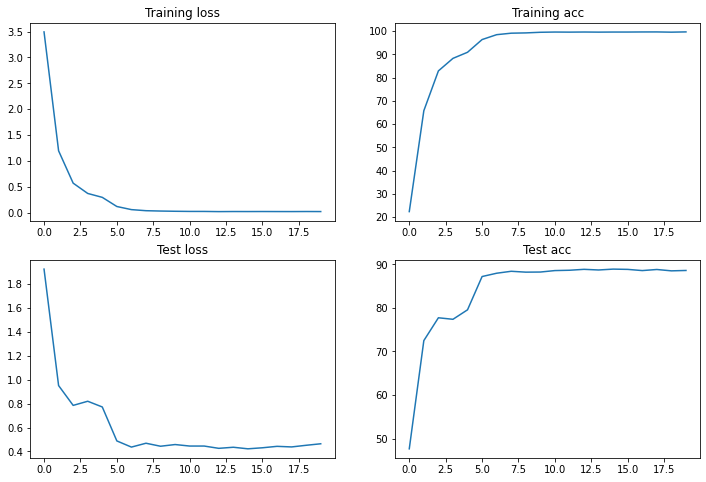

In [9]:
# plot the stats
f, axarr = plt.subplots(2,2, figsize = (12, 8))
axarr[0, 0].plot(training_losses)
axarr[0, 0].set_title("Training loss")
axarr[0, 1].plot(training_accs)
axarr[0, 1].set_title("Training acc")

axarr[1, 0].plot(test_losses)
axarr[1, 0].set_title("Test loss")
axarr[1, 1].plot(test_accs)
axarr[1, 1].set_title("Test acc")